In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from osgeo import gdal
import pickle 
import datetime 
import multiprocessing
import cartopy
import xarray as xr
import os
import glob 
import geopandas as gpd
import seaborn as sns
from pyproj import Proj, Transformer

# Correct Projection for the plots (EPSG: 3413, is specified wrongly in cartopy and is therefore manually defined)
plot_proj = cartopy.crs.Stereographic(central_longitude=-45,central_latitude=90,true_scale_latitude=70)

def open_pickle(file_path): 
    f = open(file_path, 'rb')
    return pickle.load(f)

def read_tif(file_path):
    tif = gdal.Open(file_path)
    band= tif.GetRasterBand(1)
    arr = band.ReadAsArray().astype(np.float64)
    arr[arr == 65535] = np.nan
    return arr 

def write_geotiff(filename, arr, in_ds):
    if arr.dtype == np.float32:
        arr_type = gdal.GDT_Float32
    else:
        arr_type = gdal.GDT_Int32

    driver = gdal.GetDriverByName("GTiff")
    out_ds = driver.Create(filename, arr.shape[1], arr.shape[0], 1, arr_type)
    out_ds.SetProjection(in_ds.GetProjection())
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())
    band = out_ds.GetRasterBand(1)
    band.WriteArray(arr)
    band.FlushCache()
    band.ComputeStatistics(False)


def icemask_from_tif(file_path):
    '''
    Opens a meltmap (geotif-file) and convert it into a ice mask. Since the extent of the meltmaps are always 
    the same a random melt scene can be used to generate the icemask. Bedrock and ocean are set to np.nan whereas 
    ice is set to 1. 
    
    Input: file_path: Path to meltmap
    Output: icemask: a mask consising of either 1 or nan. 
    '''
    
    icemask = read_tif(file_path)
    # Ocean and bedrock is set to nan. 
    icemask[icemask >= 5] = np.nan
    # Different classes of melt is set to 1 
    icemask[icemask <= 4] = 1
    return icemask 

def number_of_meltdays(rcm, threshold): 
    '''
    Compute the number of meltdays in a year for a RCM. Meltdays are thresholded by a magnitude threshold only. 
    '''    
    melt = np.zeros(rcm.shape)
    #melt = np.full([365, 540, 299], np.nan)
    melt[rcm >= threshold] = 1
    sum_meltdays = np.sum(melt, axis = 0)
    sum_meltdays[sum_meltdays == 0] = np.nan
    return sum_meltdays 

def plot_greenland(data, ax, transform = cartopy.crs.epsg('3413'), mask = None, 
                   vmin = 0, vmax = 100, 
                   cbar = False, cbar_label = None, cmap = 'PuBuGn'): 
    if mask is not None: 
        # Mask data: 
        data = data * mask 
    
    plot = ax.scatter(grid_X, grid_Y, c = np.flip(data, axis =0 ), 
               transform = transform, s = 0.5, cmap = cmap, 
               vmin = vmin, vmax = vmax)
    ax.add_feature(cartopy.feature.LAND,color = 'tan', alpha = 0.7)
    ax.coastlines(resolution='50m', linewidth = 0.1)
    if cbar:
        plt.colorbar(plot , ax = ax , label = cbar_label)
        
def rolling_window(a, size):
    '''
    Takes an array (1D or 2D) and compute an array using a rolling window (2D or 3D array). The rollig array is 
    created along the first axis (i.e. time). 
    
    Input: a: The original array that the rolling array needs to be computed from. 
           size: size of the rolling window. 
    
    Output: The rolling window array. 
    '''
    
    shape = a.shape[:-1] + (a.shape[-1] - size + 1, size)
    strides = a.strides + (a.strides[-1],)
    
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def find_first_last(arr):
    '''
    Takes a 3D boolean array and finds the first and last occurence of True along the zero axis (time in this case).
    
    Input: arr: 3D boolean array
    Output: first_occurrence: The index of the first True occurence. 
            last_occurence: The index of the last True occurance
    '''
    
    # Find the index of the first occurence:  
    first_occurrence = np.argmax(arr, axis=0)
    # Flip array around and find the last occurence. Since the index correspond to the flipped array, substract 
    # with the size of array: 
    last_occurrence = arr.shape[0] - np.argmax(np.flip(arr, axis=0), axis=0) - 1
    return first_occurrence.astype(np.float32),  last_occurrence.astype(np.float32)


def melt_season(array, thresholds, length):
    
    '''
    Function used to compute the start and end of the melt season. The melt season is defined using a threshold 
    for the magnitude (either mmWE/day for RCM or class threshold for ASCAT) and a length of consective melt 
    threshold. 
    
    Input: array: a year of either daily RCM active melt or ASCAT melt classification (3D array)
           threshold: lower and upper magnitude threshold (the upper threshold for RCM should be very large as
                      there should be no upper threshold)
           length: Length threshold of how many days of consective melt defines the start and end of melt season. 
    Output; Start and end of the melt season for each pixel. 
    '''
    
    outarray = np.zeros_like(array).astype('bool') # Zero array 
    subarray1 = np.ones(length) * thresholds[0] # Lower magnitude threhold
    subarray2 = np.ones(length) * thresholds[1] # Upper magnitude threhold
    # Compute boolean for length and magnitude thresholds is statisfied: 
    index1 = np.all(rolling_window(array, length) >= subarray1, axis=2) # Lower magnitude threholding 
    index2 = np.all(rolling_window(array, length) <= subarray2, axis=2) # Upper magnitude threholding 
    index = index1 & index2 # Both magnitude thresholds 
    # Correct indexing
    outarray[:, :index.shape[1]] = index
    # Find start and end: 
    start, end = find_first_last(outarray.T)
    start[start == 0] = np.nan # Set no start of melt season to nan 
    start = start.reshape((540,299)) # Correct grid shape 
    end[end >= 364] = np.nan # Set no end of melt season to nan 
    end = end.reshape((540,299)) # Correct grid shape 
    end = end + length - 1 # correct indexing since it has to be the last day where the thresholding was satisfied
    return start, end


def rolling_window_rcm(array, threshold, length):
    outarray = np.zeros_like(array).astype('bool')
    subarray = np.ones(length) * threshold
    index = np.any(rolling_window(array, length) >= subarray, axis=2)
    outarray[:, :index.shape[1]] = index
    return outarray.T

def window_comparion(ascat, rcm, threshold, length): 
    
    '''
    Compute find the ratio (procentage) between days with melt/refreezing/no melt in both ASCAT and RCM 
    and total number of days with melt/refreezing/no melt in ASCAT. It is possible to specify a window in which 
    the RCM "looks into the future" using the length variable. If length = 1, no window is applied. 
    
    Input: ascat: Boolean-like that specifies if selected ascat claasification is satisfied. 
           rcm: RCM with daily active melt. 
           threshold: Threshold for when a day is clssified as a melt day in the RCM. 
           length: The number of days in the future included in the RCM used to account for the preporsseing 
                   window of ASCAT. If length = 1, no window is applied. 
    
    Output: The melt/refreezing/no melt ratio for each pixel in the ascat grid. Pixels where melt/refreezing/no melt
            is not detecetd by ASCAT is set to nan. 
    '''
    
    # Computed boolean array melt occurs over a threshold inside a window of specified length: 
    window_rcm = rolling_window_rcm(rcm.reshape((rcm.shape[0], -1)).T,threshold, length)
    melt_rcm = window_rcm.reshape(rcm.shape) # reshape into original dimentions to match ASCAT 
    
    # Days where 
    match = np.equal(ascat.astype('bool'), melt_rcm).astype('float')
    # Exclude indexs where ASCAT is False: 
    match[ascat == 0] = np.nan
    # Sum days: 
    sum_match = np.nansum(match, axis = 0)
    sum_ascat = np.nansum(ascat, axis = 0)
    return np.divide(sum_match,sum_ascat)*100 # Computed ratio. 

# Choose year and import RCMs

In [5]:
year = 2016

# Load in regridded RCMs:
hirham = open_pickle(f'/home/annpug/Desktop/annpug/regriddedRCM/HIRHAM_{year}_regridded_nearest.pkl')
racmo = open_pickle(f'/home/annpug/Desktop/annpug/regriddedRCM/RACMO_{year}_regridded_nearest.pkl')
mar = open_pickle(f'/home/annpug/Desktop/annpug/regriddedRCM/MAR_{year}_regridded_cubic.pkl')

# create ensemble mean:
ens = np.stack((hirham,racmo,mar), axis=-1)
ens_mean = np.mean(ens, axis = 3)

# load a random scene and convert it to the an icemask: 
ascat_mask = icemask_from_tif('/mnt/h1/projects/4DGreenland/meltmap_v01/ASCAT/2018/meltmap_2018-09-24.tif')

# Load grid; 
grid = xr.open_dataset('/home/annpug/Desktop/annpug/tif_grid.nc')
grid_X, grid_Y = np.meshgrid(grid.x,grid.y)

# Compute onset, end and duration of melt season for RCM

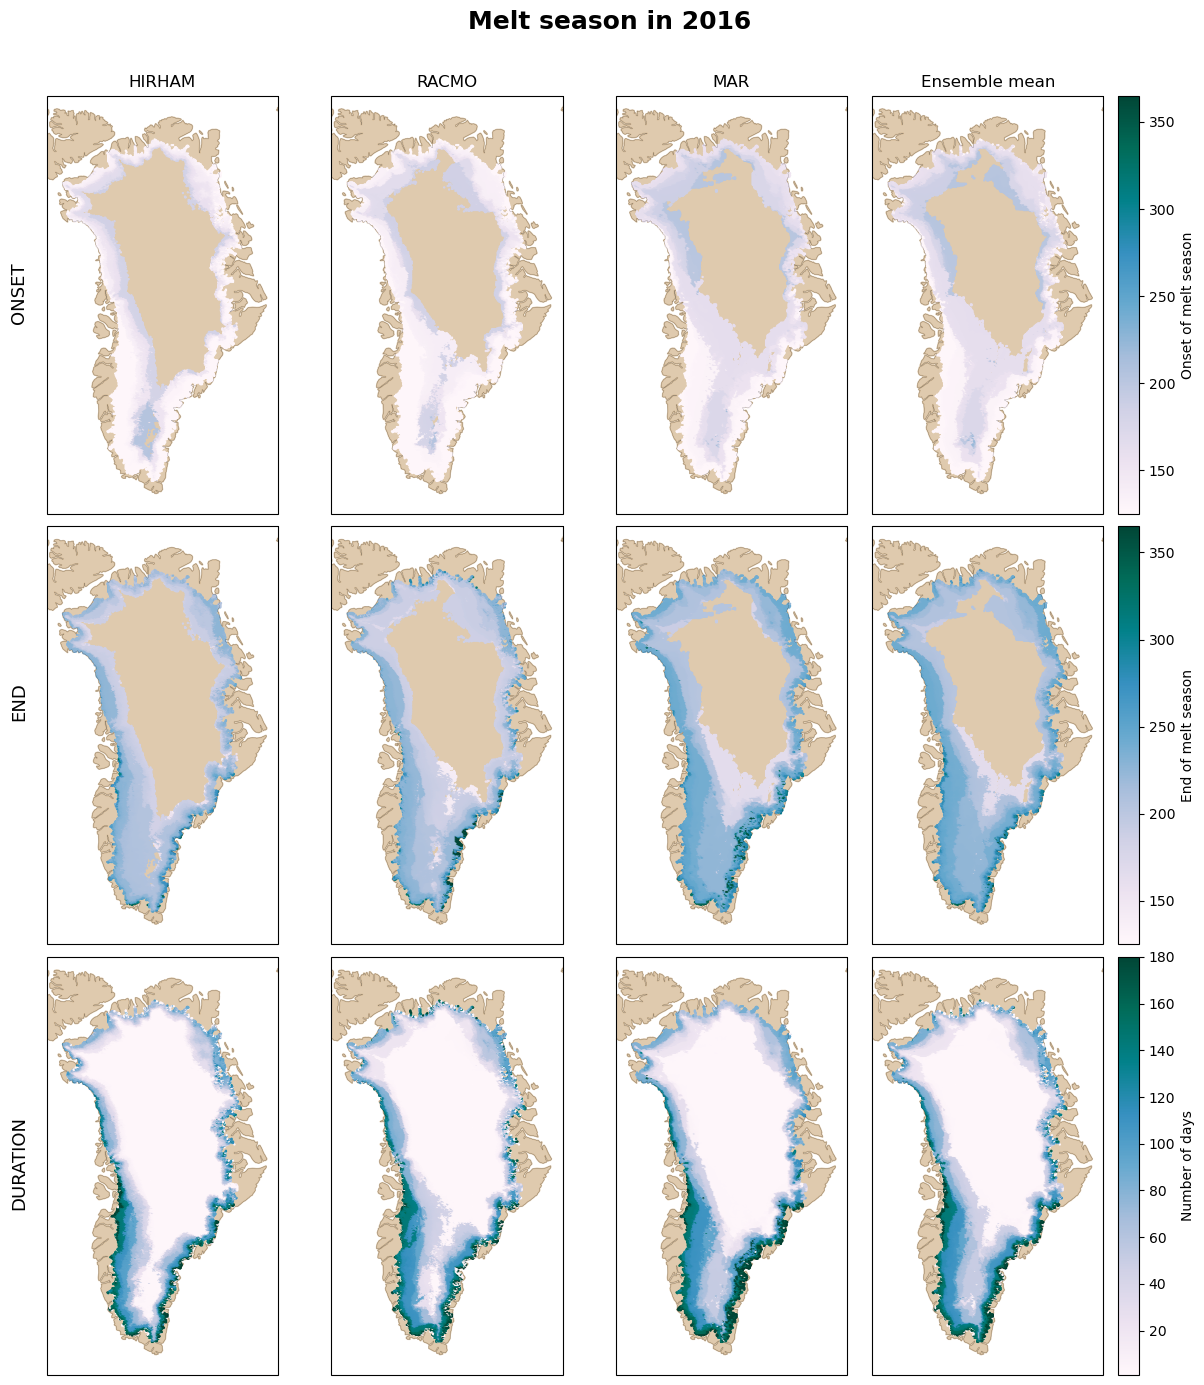

In [19]:
len_threshold = 3 # Number of consecutive days with active melt in order to classify the melt season. 
magn_threshold = [0.5, 10000] # 10000 indicates no upper threshold for melt intensity. 

# Compute start and end of melt season for each RCM;  
start_racmo, end_racmo = melt_season(racmo.reshape((racmo.shape[0], -1)).T, magn_threshold, len_threshold)
start_hirham, end_hirham = melt_season(hirham.reshape((hirham.shape[0], -1)).T, magn_threshold, len_threshold)
start_mar, end_mar = melt_season(mar.reshape((mar.shape[0], -1)).T, magn_threshold, len_threshold)
start_ens, end_ens = melt_season(ens_mean.reshape((ens_mean.shape[0], -1)).T, magn_threshold, len_threshold)

# Compute the duration of the melt season: 
duration_hirham = end_hirham - start_hirham
duration_racmo = end_racmo - start_racmo
duration_mar = end_mar - start_mar
duration_ens = end_ens - start_ens

# Set pixels without melt days on the icesheet to 0 duration. 
duration_hirham[(duration_hirham.astype(str)==str(np.nan)) & (ascat_mask.astype(str) != str(np.nan)) ] = 0
duration_racmo[(duration_racmo.astype(str)==str(np.nan)) & (ascat_mask.astype(str) != str(np.nan)) ] = 0
duration_mar[(duration_mar.astype(str)==str(np.nan)) & (ascat_mask.astype(str) != str(np.nan)) ] = 0
duration_ens[(duration_ens.astype(str)==str(np.nan)) & (ascat_mask.astype(str) != str(np.nan)) ] = 0

 
# Plot results: 
fig, axs = plt.subplots(3, 4, figsize = (12,14), subplot_kw={'projection': plot_proj})
fig.suptitle(f'Melt season in {year}\n\n',fontsize = 18, fontweight = 'bold')
# HIRHAM plots : 
plot_greenland(start_hirham, axs[0,0],  mask = ascat_mask, vmin = 150, vmax = 365)
plot_greenland(end_hirham, axs[1,0],  mask = ascat_mask, vmin = 150, vmax = 365)
plot_greenland(duration_hirham, axs[2,0], mask = ascat_mask, vmin = 1, vmax = 180)
axs[0,0].set_title('HIRHAM')

# RACMO plots : 
plot_greenland(start_racmo, axs[0,1],   mask = ascat_mask, vmin = 150, vmax = 365)
plot_greenland(end_racmo, axs[1,1],  mask = ascat_mask, vmin = 150, vmax = 365)
plot_greenland(duration_racmo, axs[2,1],  mask = ascat_mask, vmin = 1, vmax = 180)
axs[0,1].set_title('RACMO')

# MAR plots 
plot_greenland(start_mar, axs[0,2],  mask = ascat_mask,  vmin = 125, vmax = 365)
plot_greenland(end_mar, axs[1,2],  mask = ascat_mask,  vmin = 125, vmax = 365) 
plot_greenland(duration_mar, axs[2,2],  mask = ascat_mask,  vmin = 1, vmax = 180)
axs[0,2].set_title('MAR')

# Ensemble mean plots 
plot_greenland(start_ens, axs[0,3],   mask = ascat_mask, cbar = True,  
               cbar_label = 'Day of the year', 
               vmin = 125, vmax = 365)
plot_greenland(end_ens, axs[1,3], mask = ascat_mask, cbar = True,  
               cbar_label = f'Day of the year', 
               vmin = 125, vmax = 365)
plot_greenland(duration_ens, axs[2,3], mask = ascat_mask, cbar = True,  
               cbar_label = f'Number of days', 
               vmin = 1, vmax = 180)
axs[0,3].set_title('Ensemble mean')
# 
plt.figtext(-0, 0.8, 'ONSET', ha='left', va='top', rotation = 'vertical', fontsize =13)
plt.figtext(-0, 0.5, 'END', ha='left', va='top', rotation = 'vertical', fontsize =13)
plt.figtext(-0, 0.19, 'DURATION', ha='left', va='top', rotation = 'vertical', fontsize =13)
fig.tight_layout(pad = 0.5)
plt.show()


# Load ASCAT and compute the melt season 

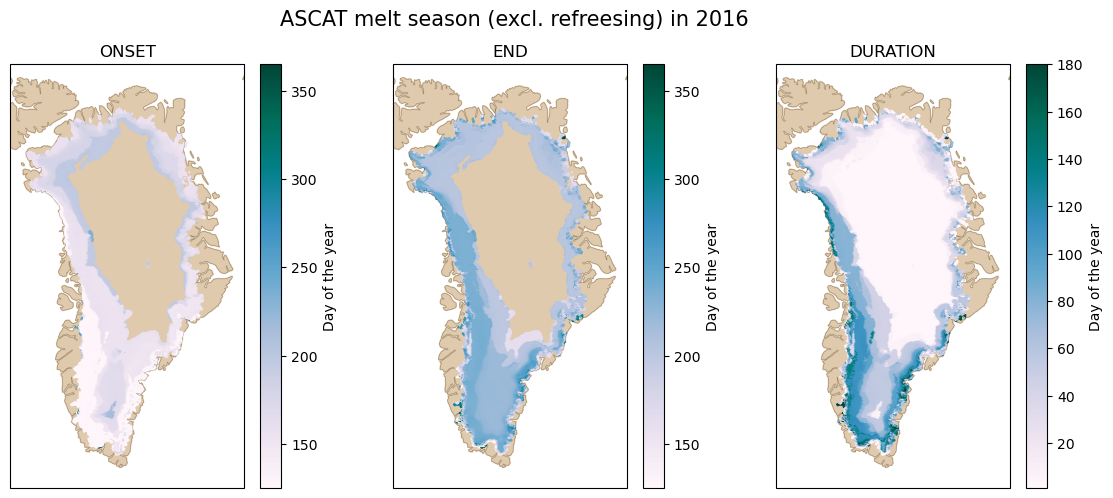

In [26]:
# Import one year of ascat meltmaps. 
ascat = []
# define the daterange for that year: 
dates_ascat = pd.date_range(datetime.date(year,1, 1), periods = racmo.shape[0])
for date in dates_ascat: 
    date_str = date.strftime('%Y-%m-%d')
    # Find file: 
    file = glob.glob(f'/mnt/h1/projects/4DGreenland/meltmap_v01/ASCAT/{year}/meltmap_{date_str}.tif')
    # if there is no file then make it completely no melt. This can only be done since the meltmaps already have 
    # filled datagaps and therefore only a few winter days are missing (except for 2019 where summer data is missing)
    if len(file) == 0: 
        tif = ascat_mask
        tif[tif == 1] = 0
    # if there is a file then open it: 
    else: 
        tif = read_tif(file[0])
        tif[tif >= 5] = np.nan # Set bedrock and ocean to nan. 
    
    ascat.append(tif) # Append to data array    
    
ascat = np.array(ascat)  

# Save as pickle:
with open(f'/home/annpug/Desktop/annpug/ascat_{year}.pkl','wb') as f:
    pickle.dump(ascat, f)

# Melt season begins when the next three days also have melt and ends with the last 3 days of refree: 
ascat_threshold = 2
# Melt is defined as either class 1 or class 2; (eg. excluding the refreezing class): 
onset_ascat, end_ascat = melt_season(ascat.reshape((ascat.shape[0], -1)).T, [0.9, 2.1], ascat_threshold)
# Compute duration of melt season: 
duration_ascat = end_ascat - onset_ascat
# Set pixels without a melt season but inside the icemask to zero:
duration_ascat[(duration_ascat.astype(str)==str(np.nan)) & (ascat_mask.astype(str) != str(np.nan)) ] = 0

# Plot results 
fig, axs = plt.subplots(1, 3, figsize = (14,5.5), subplot_kw={'projection': plot_proj})
fig.suptitle(f'ASCAT melt season (excl. refreesing) in {year}\n', fontsize = 15)
plot_greenland(onset_ascat, axs[0], vmin = 125, vmax = 365, cbar = True, cbar_label = f'Day of the year' )
axs[0].set_title('ONSET')
plot_greenland(end_ascat , axs[1], vmin = 125, vmax = 365, cbar = True, cbar_label = f'Day of the year')
axs[1].set_title('END')
plot_greenland(duration_ascat, axs[2], vmin = 1, vmax = 180, cbar = True, cbar_label = f'Day of the year')
axs[2].set_title('DURATION')
plt.show()

# Maps with differences bewteen melt season in ASCAT and RCMs

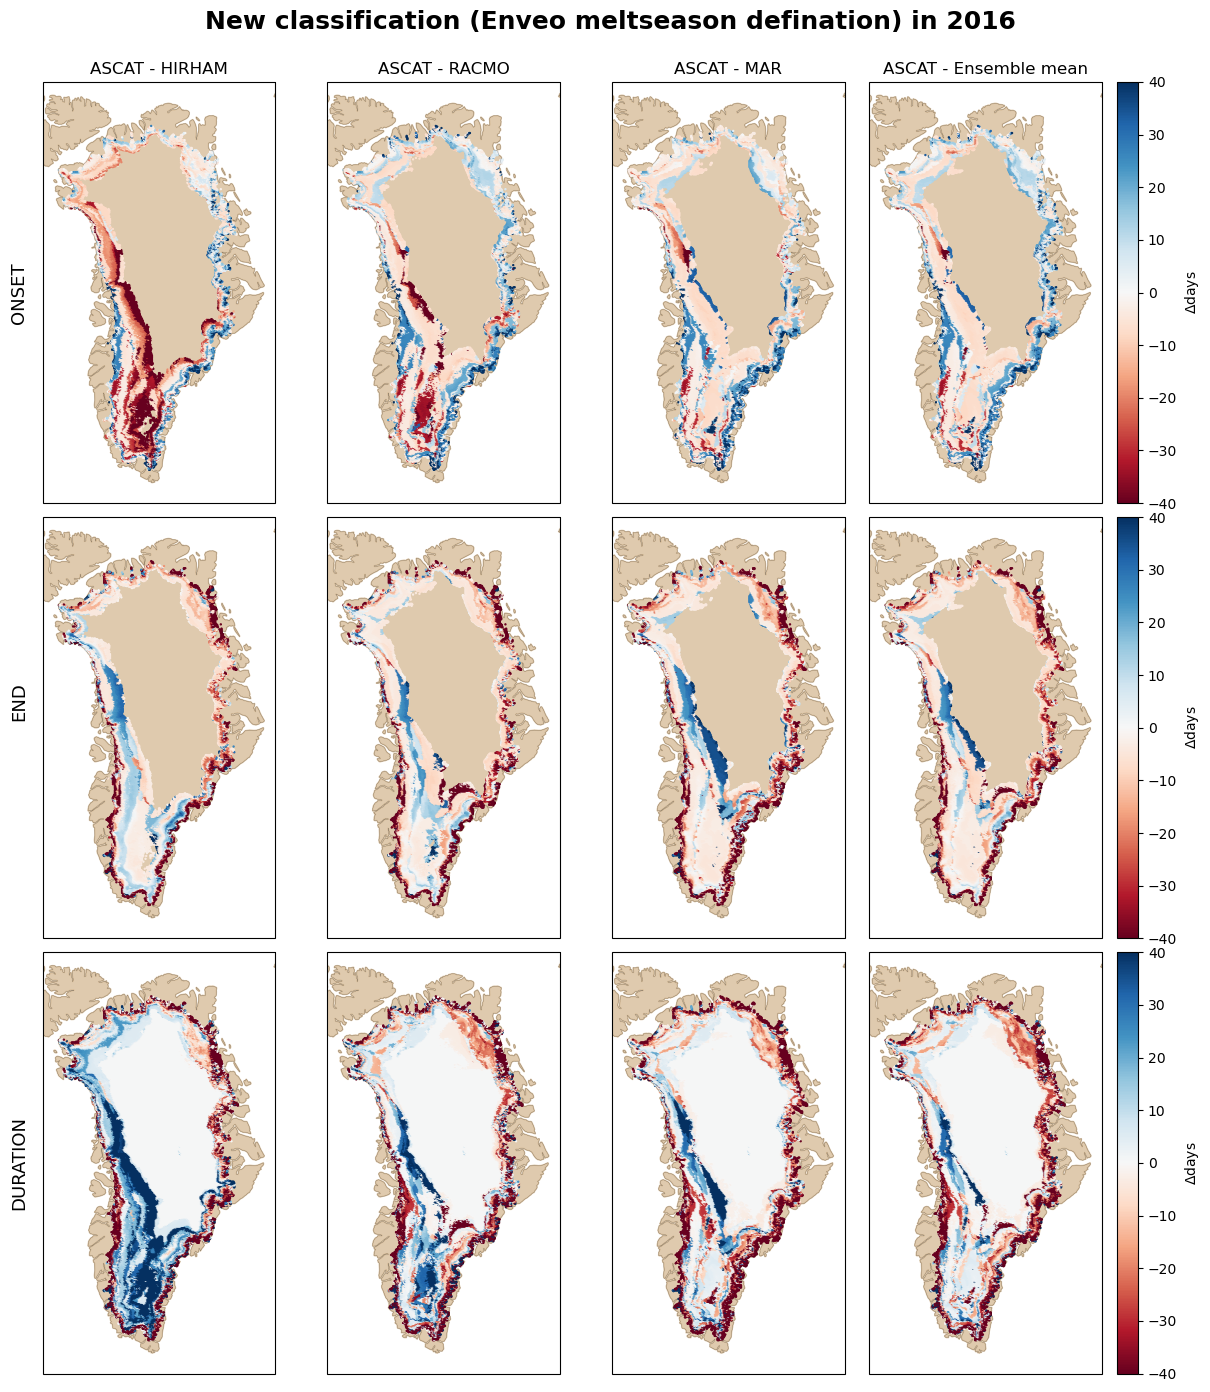

In [27]:
# Plot settings: 
cmap = 'RdBu'
minlim = -40
maxlim = 40

# hirham 
onset_dif_hirham = onset_ascat- start_hirham
end_dif_hirham = end_ascat - end_hirham
duration_dif_hirham = duration_ascat - duration_hirham
# racmo 
onset_dif_racmo = onset_ascat - start_racmo
end_dif_racmo = end_ascat - end_racmo
duration_dif_racmo = duration_ascat - duration_racmo 
# mar
onset_dif_mar = onset_ascat - start_mar
end_dif_mar = end_ascat - end_mar
duration_dif_mar = duration_ascat- duration_mar 
# ensemble mean 
onset_dif_ens = onset_ascat - start_ens
end_dif_ens = end_ascat - end_ens
duration_dif_ens = duration_ascat - duration_ens


# Plot of results 
fig, axs = plt.subplots(3, 4, figsize = (12,14), subplot_kw={'projection': plot_proj})
fig.suptitle(f'New classification (Enveo meltseason defination) in {year}\n\n', fontsize = 18, fontweight = 'bold')
# Hirham 
plot_greenland(onset_dif_hirham, axs[0,0], vmin = minlim, vmax = maxlim, cmap = cmap)
plot_greenland(end_dif_hirham, axs[1,0], vmin = minlim, vmax = maxlim, cmap = cmap)
plot_greenland(duration_dif_hirham, axs[2,0], vmin = minlim, vmax = maxlim, cmap = cmap)
axs[0,0].set_title('ASCAT - HIRHAM')
axs[0,1].set_ylabel('ONSET')
axs[1,1].set_ylabel('END')
axs[2,1].set_ylabel('DURATION')
# racmo 
plot_greenland(onset_dif_racmo, axs[0,1],  vmin =minlim, vmax = maxlim, cmap = cmap)
plot_greenland(end_dif_racmo, axs[1,1],  vmin = minlim, vmax = maxlim, cmap = cmap)
plot_greenland(duration_dif_racmo, axs[2,1],  vmin = minlim, vmax = maxlim, cmap = cmap)
axs[0,1].set_title('ASCAT - RACMO')
# mar 
plot_greenland(onset_dif_mar, axs[0,2],  vmin = minlim, vmax = maxlim, cmap = cmap)
plot_greenland(end_dif_mar, axs[1,2],   vmin = minlim, vmax = maxlim, cmap = cmap)
plot_greenland(duration_dif_mar, axs[2,2],  vmin = minlim, vmax = maxlim, cmap = cmap)
axs[0,2].set_title('ASCAT - MAR')
# ensembel mean 
plot_greenland(onset_dif_ens, axs[0,3],  cbar = True,  
               cbar_label = r'$\Delta$days', 
               vmin = minlim, vmax = maxlim, cmap = cmap)
plot_greenland(end_dif_ens, axs[1,3],  cbar = True,  
               cbar_label = r'$\Delta$days', 
               vmin = minlim, vmax = maxlim, cmap = cmap)
plot_greenland(duration_dif_ens, axs[2,3],  cbar = True,  
               cbar_label = r'$\Delta$days', 
               vmin = minlim, vmax = maxlim, cmap = cmap)
axs[0,3].set_title('ASCAT - Ensemble mean')
plt.figtext(-0, 0.8, 'ONSET', ha='left', va='top', rotation = 'vertical', fontsize =13)
plt.figtext(-0, 0.5, 'END', ha='left', va='top', rotation = 'vertical', fontsize =13)
plt.figtext(-0, 0.19, 'DURATION', ha='left', va='top', rotation = 'vertical', fontsize =13)
fig.tight_layout(pad = 0)
plt.show()

# Compare number of melt days 

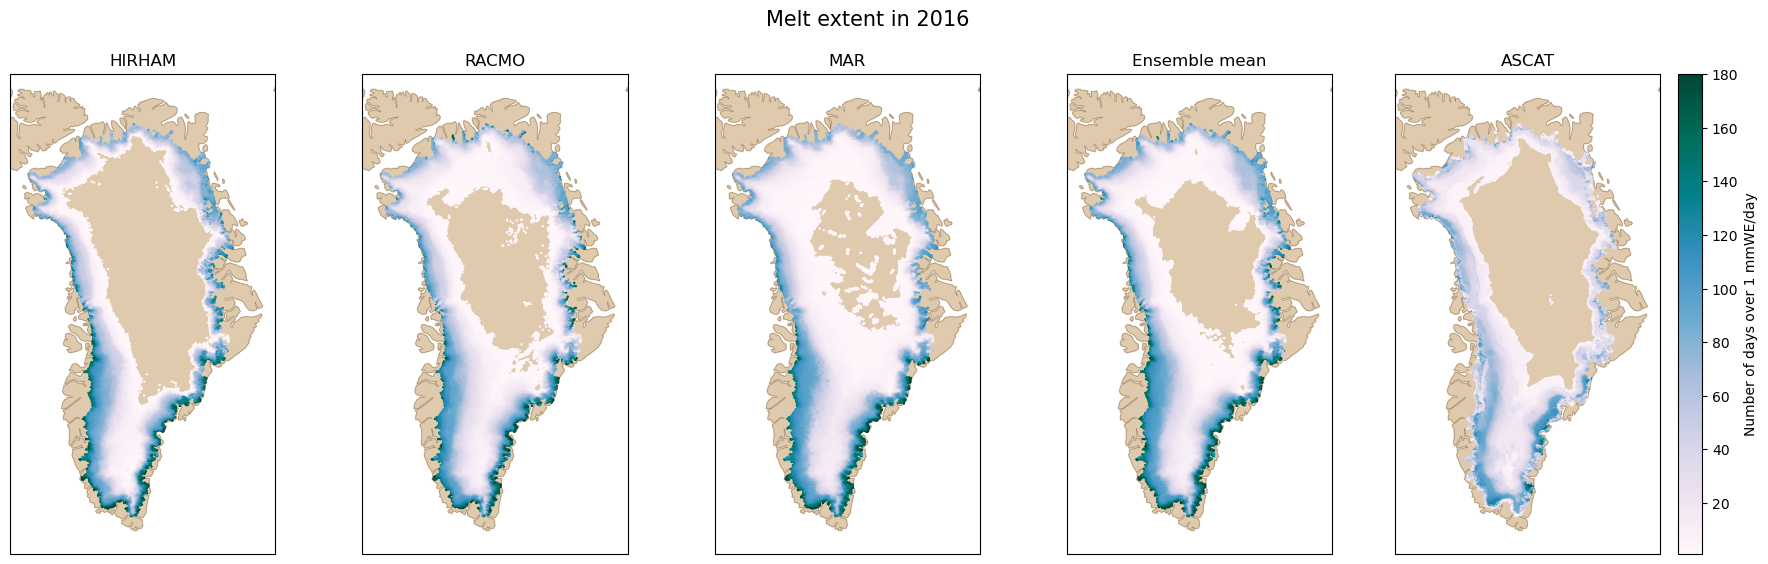

In [51]:
# Compute the number of days where melt is over the specified threshold:
threshold = 1
meltdays_racmo = number_of_meltdays(racmo,threshold)
meltdays_hirham = number_of_meltdays(hirham,threshold)
meltdays_mar = number_of_meltdays(mar,threshold)
meltdays_ens = number_of_meltdays(ens_mean,threshold)

# Compute number of melt days for ASCAT 
melt_ascat = np.zeros(ascat.shape)
melt_ascat[(ascat >= 1) & (ascat <= 2)] = 1
meltdays_ascat = np.sum(melt_ascat, axis = 0) # Sum to get the number of days in each pixel
meltdays_ascat[meltdays_ascat == 0] = np.nan

# Plot results: 
fig, axs = plt.subplots(1, 5, figsize = (18,5.5), subplot_kw={'projection': plot_proj})
fig.suptitle(f'Melt extent in {year}\n\n', fontsize = 15)
plot_greenland(meltdays_hirham, axs[0], mask = ascat_mask, vmin = 1, vmax = 180)
axs[0].set_title('HIRHAM')
plot_greenland(meltdays_racmo, axs[1], mask = ascat_mask, vmin = 1, vmax = 180)
axs[1].set_title('RACMO')
plot_greenland(meltdays_mar, axs[2], mask = ascat_mask,  vmin = 1, vmax = 180)
axs[2].set_title('MAR')
plot_greenland(meltdays_ens, axs[3], mask = ascat_mask, vmin = 1, vmax = 180)
axs[3].set_title('Ensemble mean')
plot_greenland(meltdays_ascat, axs[4], mask = ascat_mask, cbar = True,  
               cbar_label = f'Number of days over {threshold} mmWE/day', 
               vmin = 1, vmax = 180)
axs[4].set_title('ASCAT')
fig.tight_layout(pad = -0.4)
plt.show()

## a) Melt days ratio 

/tmp/ipykernel_12779/2095330518.py:186: RuntimeWarning: invalid value encountered in divide
  return np.divide(sum_match,sum_ascat)*100 # Computed ratio.


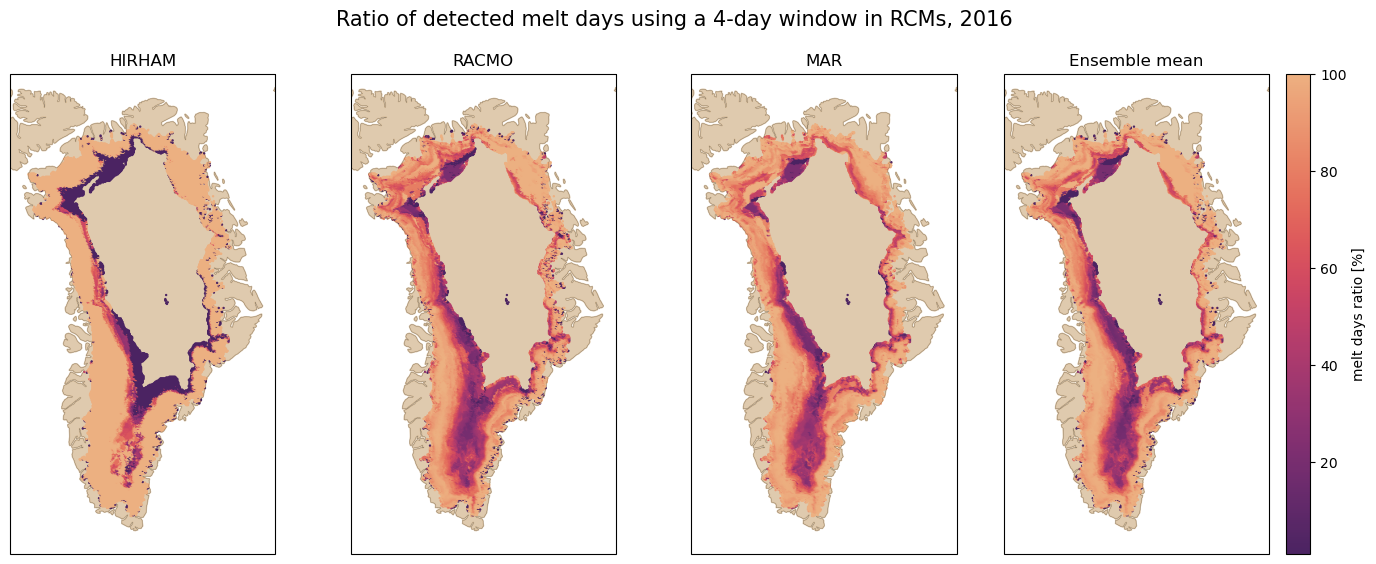

In [43]:
cmap = sns.color_palette("flare_r", as_cmap=True)
window = 4


match_hirham = window_comparion(melt_ascat, hirham, 1, window)
match_racmo = window_comparion(melt_ascat, racmo, 1,  window)
match_mar = window_comparion(melt_ascat, mar, 1, window)
match_ens = window_comparion(melt_ascat, ens_mean, 1, window)
                               
# Plot
fig, axs = plt.subplots(1, 4, figsize = (14,5.5), subplot_kw={'projection': cartopy.crs.NorthPolarStereo(central_longitude=-45)})
fig.suptitle(f'Ratio of detected melt days using a {window}-day window in RCMs, {year}\n\n', fontsize = 15)
plot_greenland(match_hirham, axs[0],  vmin = 0, vmax = 30,  cmap=cmap)
axs[0].set_title('HIRHAM')
plot_greenland(match_racmo, axs[1], vmin = 0, vmax = 100, cmap=cmap)
axs[1].set_title('RACMO')
plot_greenland(match_mar, axs[2],   vmin = 0, vmax = 100, cmap=cmap)
axs[2].set_title('MAR')
plot_greenland(match_ens, axs[3],  cbar = True,  
               cbar_label = f'melt days ratio [%]', 
               vmin = 1, vmax = 100, cmap=cmap)
axs[3].set_title('Ensemble mean')
fig.tight_layout(pad = -0.4)
plt.show()

## b) Refreezing ratio

/tmp/ipykernel_12779/2095330518.py:186: RuntimeWarning: invalid value encountered in divide
  return np.divide(sum_match,sum_ascat)*100 # Computed ratio.


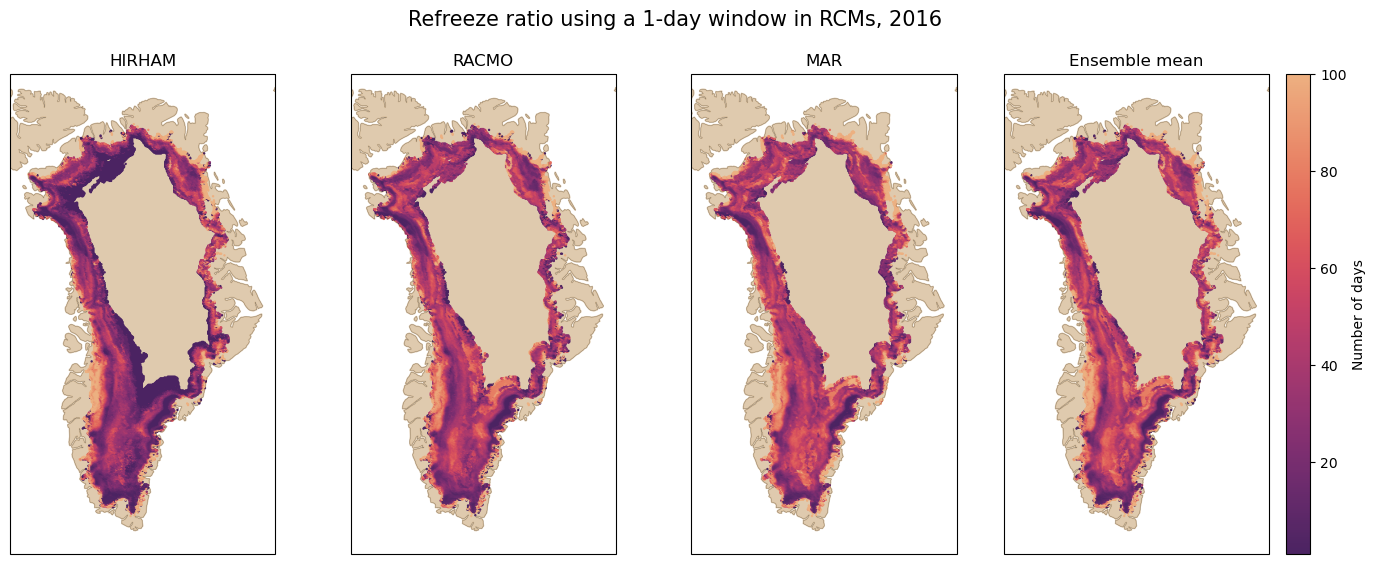

In [45]:
window_refreeze = 1
refreeze_ascat = np.zeros(ascat.shape)
refreeze_ascat[ascat == 3] = 1

match_refreeze_hirham = window_comparion(refreeze_ascat, hirham, 1, window_refreeze)
match_refreeze_racmo = window_comparion(refreeze_ascat, racmo, 1,  window_refreeze)
match_refreeze_mar = window_comparion(refreeze_ascat, mar, 1, window_refreeze)
match_refreeze_ens = window_comparion(refreeze_ascat, ens_mean, 1, window_refreeze)

# Plot
fig, axs = plt.subplots(1, 4, figsize = (14,5.5), subplot_kw={'projection': cartopy.crs.NorthPolarStereo(central_longitude=-45)})
fig.suptitle(f'Refreeze ratio using a {window_refreeze}-day window in RCMs, {year}\n\n', fontsize = 15)
plot_greenland(match_refreeze_hirham, axs[0],  vmin = 0, vmax = 100,  cmap=cmap)
axs[0].set_title('HIRHAM')
plot_greenland(match_refreeze_racmo, axs[1],  vmin = 0, vmax = 100, cmap=cmap)
axs[1].set_title('RACMO')
plot_greenland(match_refreeze_mar, axs[2],    vmin = 0, vmax = 100, cmap=cmap)
axs[2].set_title('MAR')
plot_greenland(match_refreeze_ens, axs[3],  cbar = True,  
               cbar_label = f'Number of days', 
               vmin = 1, vmax = 100, cmap=cmap)
axs[3].set_title('Ensemble mean')
fig.tight_layout(pad = -0.4)
plt.show()

## c) Differentiation of intermidiate aend end refreeze

In [149]:
end_refreeze = np.argwhere((refreeze_ascat[:-1,:,:] - refreeze_ascat[1:,:,:]) == 1)
sorted_end_indices = np.lexsort((end_refreeze[:, 2], end_refreeze [:, 1]))
end_refreeze = end_refreeze[sorted_end_indices]

start_refreeze = np.argwhere((refreeze_ascat[:-1,:,:] - refreeze_ascat[1:,:,:]) == -1)
sorted_start_indices = np.lexsort((start_refreeze[:, 2],start_refreeze [:, 1]))
start_refreeze = start_refreeze[sorted_start_indices]


intermidiate_refreeze_ascat = np.zeros(ascat.shape)
end_refreeze_ascat = np.zeros(ascat.shape) 

for i in range(len(end_refreeze)):
    ascat_after_refreeze = ascat[end_refreeze[i,0]+1:, end_refreeze[i,1], end_refreeze[i,2]]
    
    # If the melt is detected after refreezing; 
    if sum(ascat_after_refreeze) > 0: 
        intermidiate_refreeze_ascat[start_refreeze[i,0]+1:end_refreeze[i,0]+1,end_refreeze[i, 1], end_refreeze[i,2]] = 1
    # No melt class after refreezing: 
    if sum(ascat_after_refreeze) == 0: 
        end_refreeze_ascat[start_refreeze[i,0]+1:end_refreeze[i,0]+1,end_refreeze[i, 1], end_refreeze[i,2]] = 1


/tmp/ipykernel_15549/4273480225.py:104: RuntimeWarning: invalid value encountered in divide
  return np.divide(sum_melt_match,sum_melt_ascat)*100


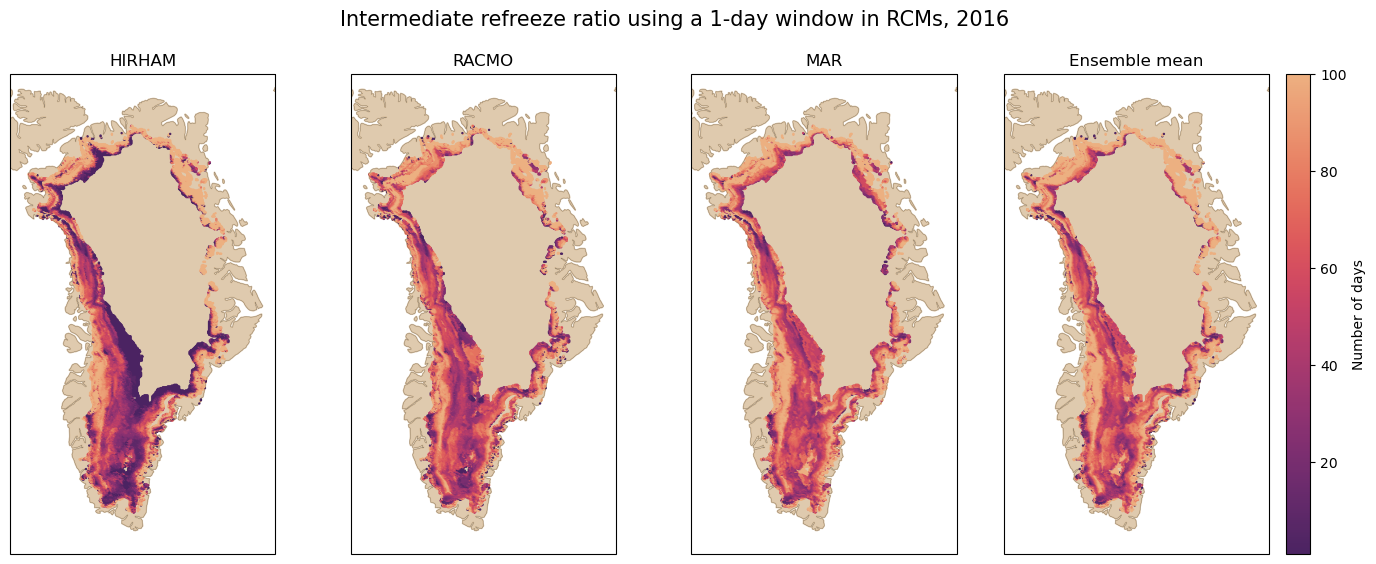

In [150]:
match_inter_refreeze_hirham = window_comparion(intermidiate_refreeze_ascat, hirham, 1, window_refreeze)
match_inter_refreeze_racmo = window_comparion(intermidiate_refreeze_ascat, racmo, 1,  window_refreeze)
match_inter_refreeze_mar = window_comparion(intermidiate_refreeze_ascat, mar, 1, window_refreeze)
match_inter_refreeze_ens = window_comparion(intermidiate_refreeze_ascat, ens_mean, 1, window_refreeze)    

# Plot
fig, axs = plt.subplots(1, 4, figsize = (14,5.5), subplot_kw={'projection': cartopy.crs.NorthPolarStereo(central_longitude=-45)})
fig.suptitle(f'Intermediate refreeze ratio using a {window_refreeze}-day window in RCMs, {year}\n\n', fontsize = 15)
plot_greenland(match_inter_refreeze_hirham, axs[0], crs_epsg, vmin = 0, vmax = 100,  cmap=cmap)
axs[0].set_title('HIRHAM')
plot_greenland(match_inter_refreeze_racmo, axs[1], crs_epsg,  vmin = 0, vmax = 100, cmap=cmap)
axs[1].set_title('RACMO')
plot_greenland(match_inter_refreeze_mar, axs[2], crs_epsg,    vmin = 0, vmax = 100, cmap=cmap)
axs[2].set_title('MAR')
plot_greenland(match_inter_refreeze_ens, axs[3], crs_epsg,  cbar = True,  
               cbar_label = f'Number of days', 
               vmin = 1, vmax = 100, cmap=cmap)
axs[3].set_title('Ensemble mean')
fig.tight_layout(pad = -0.4)
plt.show()

/tmp/ipykernel_15549/4273480225.py:104: RuntimeWarning: invalid value encountered in divide
  return np.divide(sum_melt_match,sum_melt_ascat)*100


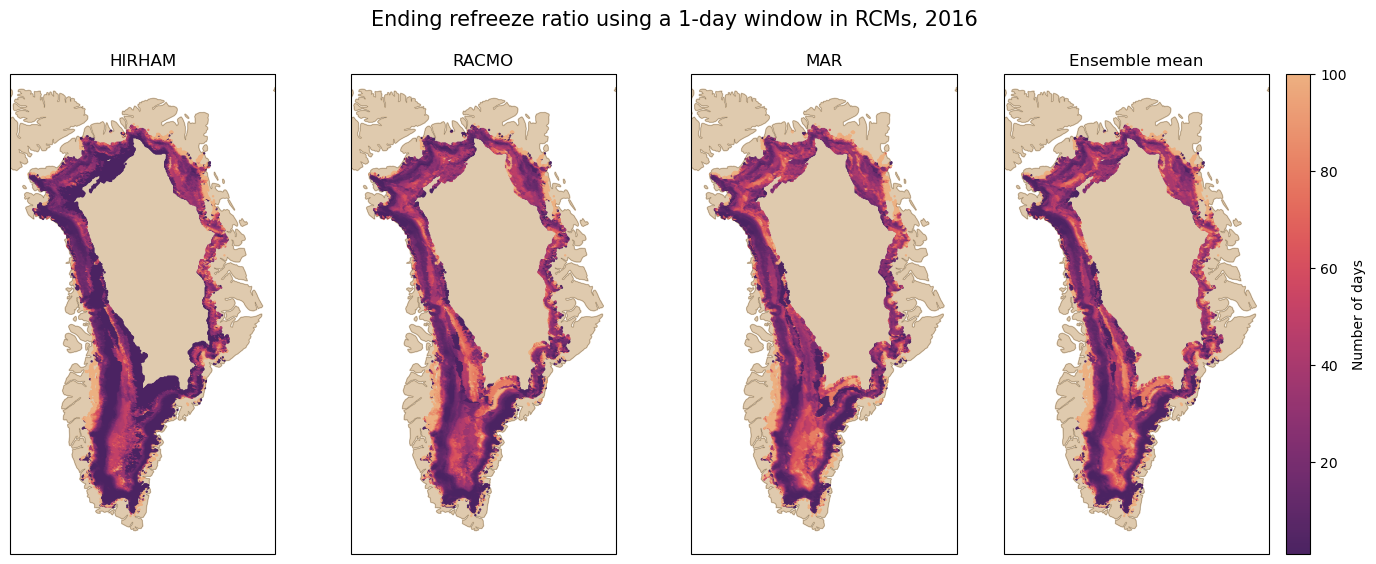

In [151]:
match_end_refreeze_hirham = window_comparion(end_refreeze_ascat, hirham, 1, window_refreeze)
match_end_refreeze_racmo = window_comparion(end_refreeze_ascat, racmo, 1,  window_refreeze)
match_end_refreeze_mar = window_comparion(end_refreeze_ascat, mar, 1, window_refreeze)
match_end_refreeze_ens = window_comparion(end_refreeze_ascat, ens_mean, 1, window_refreeze)    

# Plot
fig, axs = plt.subplots(1, 4, figsize = (14,5.5), subplot_kw={'projection': cartopy.crs.NorthPolarStereo(central_longitude=-45)})
fig.suptitle(f'Ending refreeze ratio using a {window_refreeze}-day window in RCMs, {year}\n\n', fontsize = 15)
plot_greenland(match_end_refreeze_hirham, axs[0], crs_epsg, vmin = 0, vmax = 100,  cmap=cmap)
axs[0].set_title('HIRHAM')
plot_greenland(match_end_refreeze_racmo, axs[1], crs_epsg,  vmin = 0, vmax = 100, cmap=cmap)
axs[1].set_title('RACMO')
plot_greenland(match_end_refreeze_mar, axs[2], crs_epsg,    vmin = 0, vmax = 100, cmap=cmap)
axs[2].set_title('MAR')
plot_greenland(match_end_refreeze_ens, axs[3], crs_epsg,  cbar = True,  
               cbar_label = f'Number of days', 
               vmin = 1, vmax = 100, cmap=cmap)
axs[3].set_title('Ensemble mean')
fig.tight_layout(pad = -0.4)
plt.show()

# Save selected results as geotif-files

In [153]:
# Get grid and geometry information from a ASCAT file (since everthing is on the same grid)
ds = gdal.Open('/mnt/h1/projects/4DGreenland/meltmap_v02/ASCAT/meltmap_v02_2016-01-02.tif')

# Melt season maps 
model = 'ens'
write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_{model}_end_{year}.tif", end_dif_ens, ds)
write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_{model}_onset_{year}.tif", onset_dif_ens, ds)
write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_{model}_duration_{year}.tif", duration_dif_ens, ds)

# Melt and refreezing ratios: 
write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_hirham_melt_days_{year}.tif",  match_hirham.astype('float32'), ds)
write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_racmo_melt_days_{year}.tif", match_racmo.astype('float32'), ds)
write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_mar_melt_days_{year}.tif", match_mar.astype('float32'), ds)
write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_ens_melt_days_{year}.tif", match_ens.astype('float32'), ds)

write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_hirham_end_refreezing_days_{year}.tif", match_end_refreeze_hirham.astype('float32'), ds)
write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_racmo_end_refreezing_days_{year}.tif", match_end_refreeze_racmo.astype('float32'), ds)
write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_mar_end_refreezing_days_{year}.tif", match_end_refreeze_mar.astype('float32'), ds)
write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_ens_end_refreezing_days_{year}.tif", match_end_refreeze_ens.astype('float32'), ds)
